In [87]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)

# Data Science Toolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import my_matplotlib_style as ms

# Data Science Visualization
import corner.corner as corner
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# FastAI Library
import fastai
from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats

# Autoencoder NN from Eric Wulff
from nn_utils import AE_big,AE_3D_200
import utils
from scipy import stats


In [72]:
# Load Trigger Jet Data 
train = pd.read_pickle('Dataset/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('Dataset/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

# What does the 4D jets data look like? The four vector column headers from ROOT LorentzVector Class
train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


In [73]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

db = basic_data.DataBunch(train_dl, valid_dl)

# Autoenconder to compress the 4D data
model = AE_3D_200()
#model = AE_big()

# MSE Mean Square Error
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()

bn_wd = False  
true_wd = True  
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

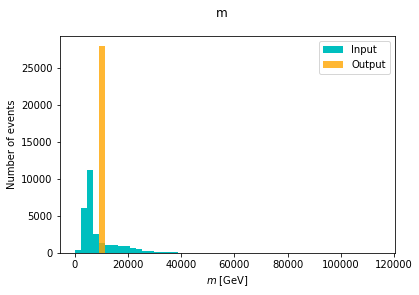

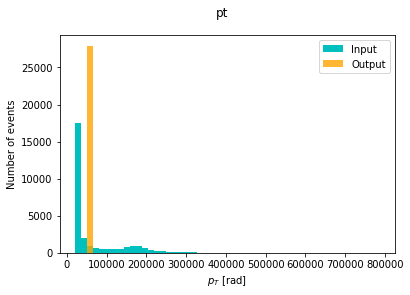

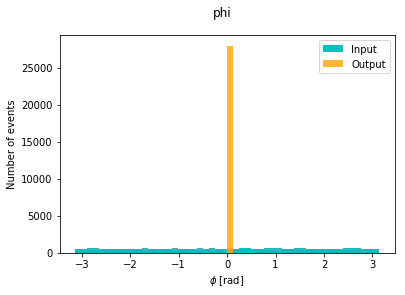

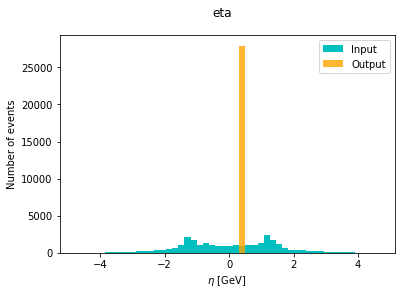

In [74]:
# Graph Labels
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    #ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [75]:
def plot_data(data, e_range=None, pt_range=None, save=False, title=True, logy=False):

    plt.figure()
    plt.hist(data['pt'], bins=100, range=pt_range)
    plt.xlabel(r'$p_T$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if logy:
        plt.yscale('log')
    if save:
        plt.savefig('data_exploration_figures/hist_pt_train.png')
    
    plt.figure()
    plt.hist(data['eta'], bins=100)
    plt.xlabel(r'$\eta$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if save:
        plt.savefig('data_exploration_figures/hist_eta_train.png')
    
    plt.figure()
    plt.hist(data['phi'], bins=100)
    plt.xlabel(r'$\phi$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if save:
        plt.savefig('data_exploration_figures/hist_phi_train.png')    
        
    plt.figure()
    plt.hist(data['m'], bins=100, range=e_range)
    plt.xlabel(r'$m$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if logy:
        plt.yscale('log')
    if save:
        plt.savefig('data_exploration_figures/hist_m_train.png')
        

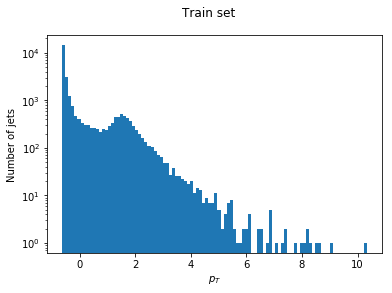

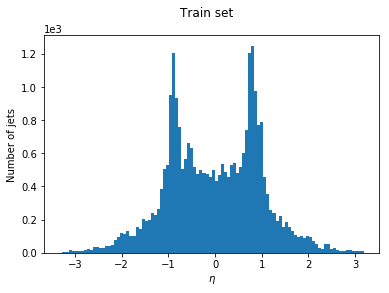

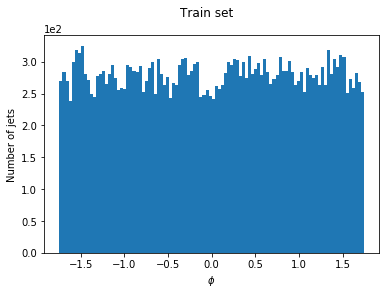

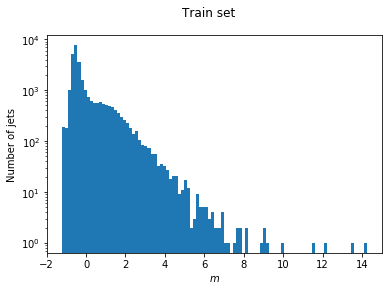

In [76]:
plot_data(test, logy=True)

In [77]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

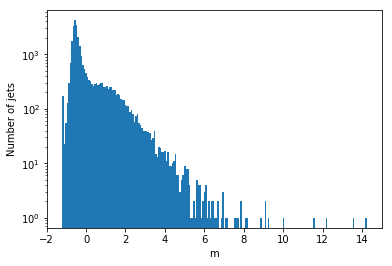

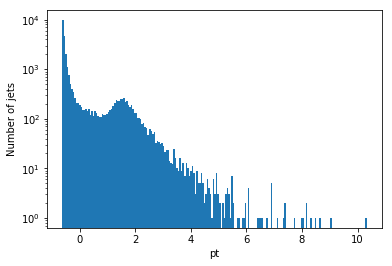

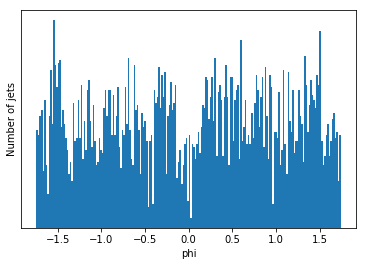

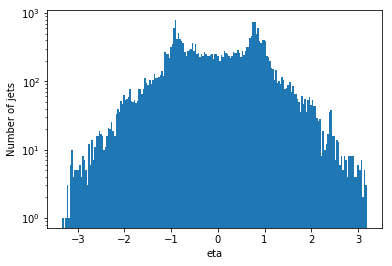

In [78]:
plot_all(test, logy=True)

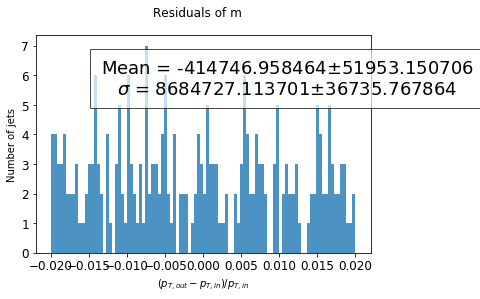

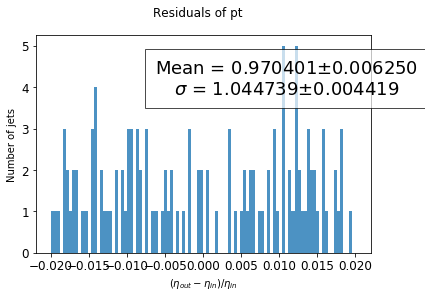

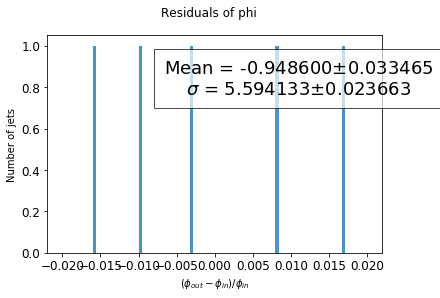

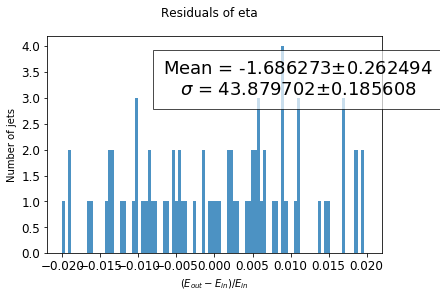

In [88]:
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]

TypeError: You must first set_array for mappable

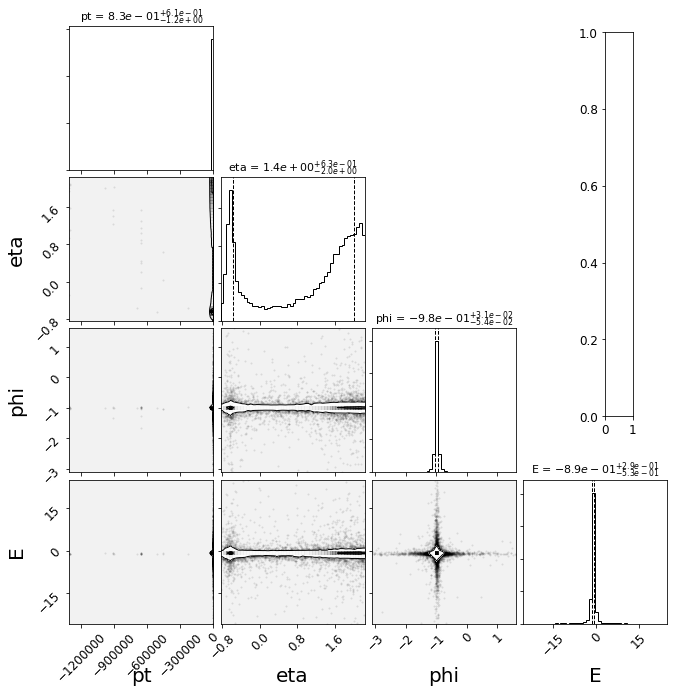

In [90]:
res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)